In [1]:
import datetime
import time

import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pgpasslib

from querymsc import WorkflowTools
%load_ext autoreload
%autoreload 2

In [2]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind=engine)
session = Session()

In [171]:
start_time = datetime.datetime(1950, 1, 1)
end_time = datetime.datetime(2018, 1, 1)

msc = WorkflowTools(start_time, end_time)

68.0


In [48]:
annual_tot_precip = msc.query_annual_precip(session)
annual_tot_rain = msc.query_annual_rain(session)
query_temp = msc.query_design_temp_percentile(session)

In [49]:
query = msc.query_design_temp_percentile(session)

In [80]:
annual_tot_precip = msc.query_annual_precip(session)
pd.read_sql(annual_tot_precip.statement, engine).head()

,annual_precip,time_min,time_max,lat,lon,station_id,obs_count,completeness
0,818.06,1990-01-01,1994-09-30,41.7833,-82.6833,6063,1734,0.949617
1,857.20,1990-01-01,1994-06-30,41.9500,-82.5167,6140,1642,0.899233
2,506.38,1990-01-01,1993-06-30,42.0333,-82.9000,6036,906,0.496166
3,503.56,1992-01-01,1994-12-31,42.0333,-82.9000,6138,1096,0.600219
4,951.42,1990-01-01,1994-12-31,42.0431,-82.6739,6040,1826,1.000000


In [79]:
annual_tot_rain = msc.query_annual_rain(session)
pd.read_sql(annual_tot_rain.statement, engine).head()

,annual_rain,time_min,time_max,lat,lon,station_id,completeness
0,755.68,1990-01-01,1994-09-30,41.7833,-82.6833,6063,0.949617
1,763.58,1990-01-01,1994-06-30,41.9500,-82.5167,6140,0.899233
2,417.90,1990-01-01,1993-06-30,42.0333,-82.9000,6036,0.464951
3,283.04,1992-06-01,1994-12-31,42.0333,-82.9000,6138,0.433187
4,875.72,1990-01-01,1994-12-31,42.0431,-82.6739,6040,1.000000


In [52]:
query_temp = msc.query_design_temp_percentile(session)
#pd.read_sql(query_temp.statement, engine)

In [53]:
query_design_temp_dry = msc.query_design_temp_dry(session)
#pd.read_sql(query_design_temp_dry.statement, engine).head()

In [54]:
query_design_temp_wet = msc.query_design_temp_wet(session)
#pd.read_sql(query_design_temp_wet.statement, engine)

In [55]:
hdd = msc.query_deg_day_below_18(session)
#pd.read_sql(hdd.statement, engine)

In [85]:
df_vars = pd.read_sql(msc.query_variables(session).statement, engine)
#df_vars[df_vars['net_var_name']=='127']
#df_vars[(df_vars['net_var_name'].astype(int) > 124) & (df_vars['net_var_name'].astype(int) < 132)]
df_vars[df_vars['standard_name'].str.contains('rain')]

,vars_id,standard_name,long_description,unit,cell_method,net_var_name
91,1380,thickness_of_rainfall_amount,Hourly rainfall,0.1 mm,time: sum,123
93,1382,rainfall_rate,5 minutes,0.1mm,,125
94,1383,rainfall_rate,10 minutes,0.1mm,,126
95,1384,rainfall_rate,15 minutes,0.1mm,,127
96,1385,rainfall_rate,30 minutes,0.1mm,,128
97,1386,rainfall_rate,1 hour,0.1mm,,129
98,1387,rainfall_rate,2 hours,0.1mm,,130
99,1388,rainfall_rate,6 hours,0.1mm,,131
100,1389,rainfall_rate,12 hours,0.1mm,,132
102,1391,rainfall_rate,24 hours,0.1mm,,161


In [185]:
rain_rate = msc.query_rain_rate_15(session)
df_rain_rate = pd.read_sql(rain_rate.statement, engine)

In [256]:
df_rain = df_rain_rate[(df_rain_rate['completeness'] > 0.85) & (df_rain_rate['rainfall_rate'] > 0) ]

In [328]:
iv = 0.1
df_gb = df_rain.groupby('station_id')#['rainfall_rate']#.pipe(lambda x: np.argwhere(np.diff(np.sign(x - iv))).flatten()[1])

from scipy import interpolate
import lmoments3 as lm
from lmoments3 import distr
from scipy.stats import gumbel_r
#paras = distr.gam.lmom_fit(x)

def fit_gumbel(x):
    #x = x['rainfall_rate'].values
    N = x.shape[0]
    euler = 0.5772156649
    if N >= 10:
        paras = distr.gum.lmom_fit(x)
        #fitted_gum = distr.gum(**paras)
        #exval = fitted_gum.ppf(0.1)
        lmoments = distr.gum.lmom(nmom=4, **paras)
        #lmoments = lm.lmom(x, nmom=2)
        alpha = lmoments[1]/np.log(2)
        xi = lmoments[0] - euler*alpha 
        ok = get_gumbel_design_value(xi, alpha)
        
        fitted_gum = distr.gum(**paras)
        val = fitted_gum.ppf(0.1)
        return ok, xi, alpha
    else:
        return np.nan
    
def get_gumbel_design_value(xi, alpha):
    gamma = 0.1 + np.exp(-np.exp(xi/alpha))
    est = xi - alpha*np.log(-np.log(gamma))
    return est

def type_i_gumbel(x, mu, beta):
    A = (1./beta)*np.exp(-(x-mu)/beta)
    B = np.exp(-np.exp(-(x-mu)/beta))
    return A*B

def type_i_gumbel_cdf(x, mu, beta):
    B = np.exp(-np.exp(-(x-mu)))
    return B


dv = []
#df_rain_before = df_rain.groupby('station_id')['rainfall_rate'].apply(fit_gumbel)
df_rain_new = df_rain.join(df_rain.groupby('station_id')['rainfall_rate'].apply(fit_gumbel), on='station_id', rsuffix='_new')

#for name, group in df_gb:
#    if group.values.shape[0] >= 10:
#        # print the data of that regiment
#        #print('group', group.values)
#        #print(group['rainfall_rate'])
#        df_grouped.groupby(level=[0, 1, 2]).apply(fancy_func)
#    df_gb.['new'] = fit_gumbel(group['rainfall_rate'].values)
#
station_list = df_rain_new['station_id'].unique()

In [329]:
df_station = df_rain_new[df_rain_new['station_id'] == station_list[0]]
vals, rain = np.histogram(df_station['rainfall_rate'].values)
vals = vals/df_station['rainfall_rate'].shape[0]
dval, xi, alpha = zip(*df_station['rainfall_rate_new'])
gum = gumbel_r.pdf(df_station['station_id'].values, scale=alpha, loc=xi)
vals.shape, rain.shape

((10,), (11,))

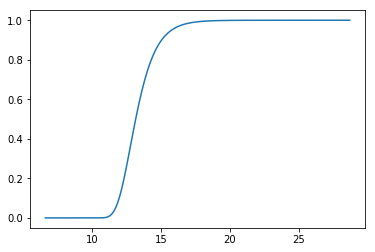

In [330]:
x_vals = np.linspace(rain.min(), rain.max(), 200)
y_vals = type_i_gumbel(x_vals, xi[0], alpha[0])

x_vals_cdf = np.linspace(rain.min(), rain.max(), 200)
y_vals_cdf = type_i_gumbel_cdf(x_vals, xi[0], alpha[0])

#sns.distplot(df_station['rainfall_rate'].values)
plt.plot(x_vals_cdf, y_vals_cdf)

In [325]:
x, y = zip(*df_rain['rainfall_rate_new'].dropna())
plt.scatter(x, y)

KeyError: 'rainfall_rate_new'

KeyError: 'rainfall_rate_new'

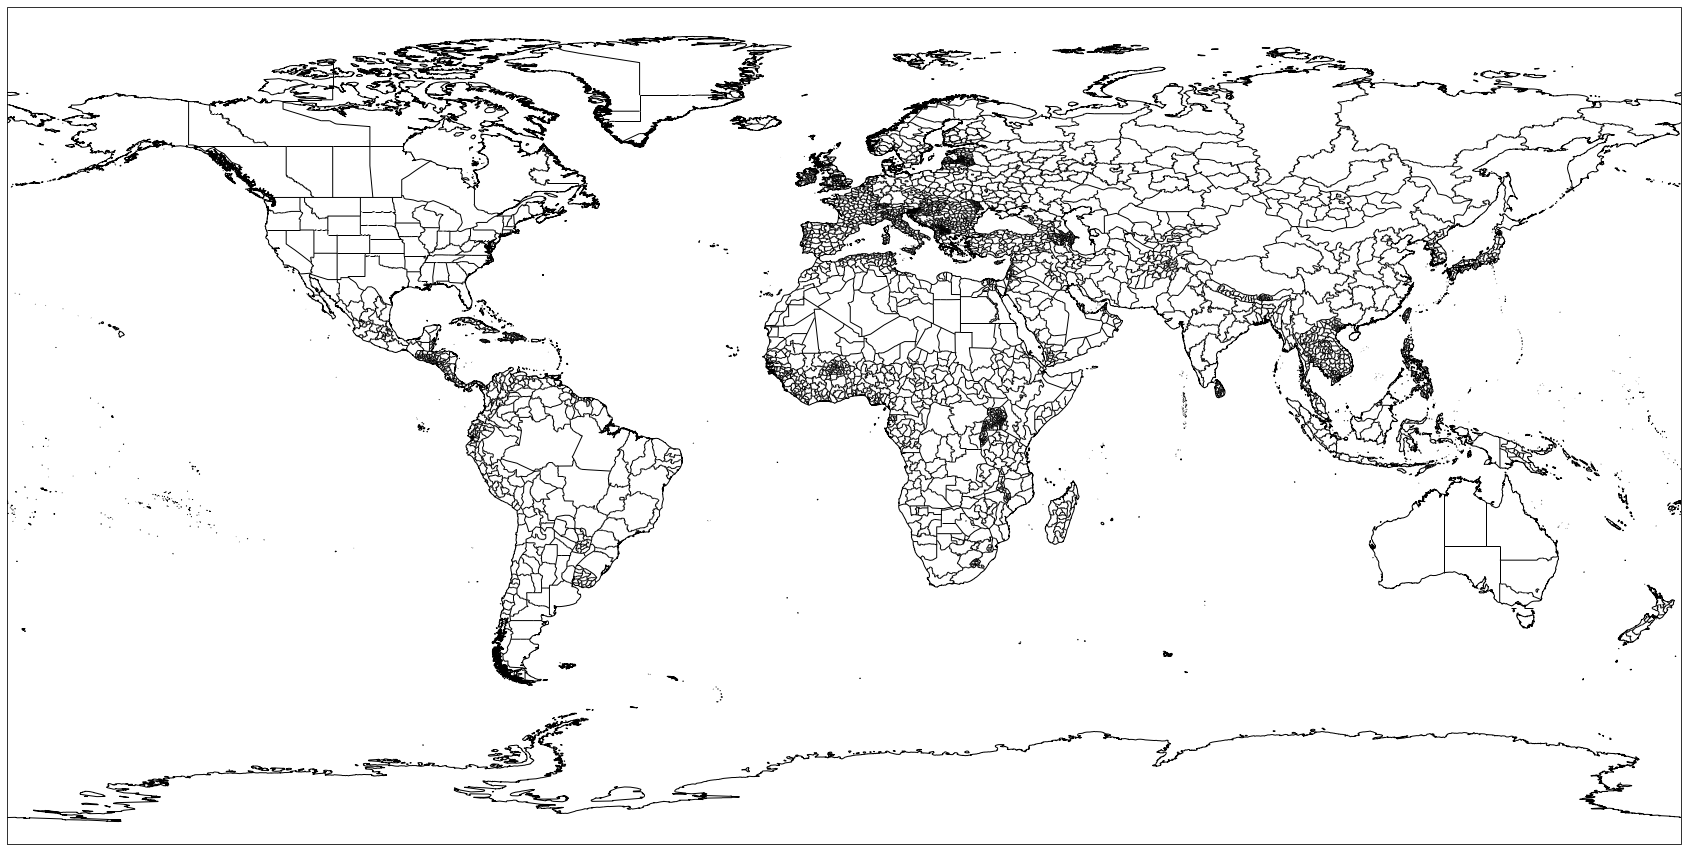

In [326]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (30, 45))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

#sns.scatterplot(x='lon', y='lat', data=df_1, hue='dd_sum')#

#df_new = df_1[(df_1['lat'] < 61.0)&(df_1['lat'] > 45.0)&(df_1['lon'] > -138)&(df_1['lon'] < -114)]

sns.scatterplot(df_rain['lon'], df_rain['lat'], hue=df_rain['rainfall_rate_new'], palette="winter", alpha=.3)
plt.ylim(40, 80)
#plt.xlim(-126, -119)
plt.savefig('./plots/canada_15_min_rain.pdf')


In [443]:
#df_rain['15_min_rain_extreme']

In [365]:
#df_rain_rate['obs_count'].value_counts().idxmax()

In [366]:
df_dv = pd.DataFrame(dv, columns=['dv'])

In [367]:
df_dv

,dv
0,4.230989
1,6.475732
2,3.763945
3,5.438313
4,4.721381
5,4.270647
6,4.175265
7,7.563507
8,7.414885
9,6.583697


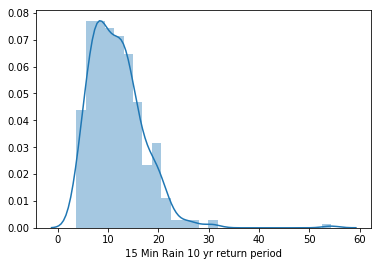

In [373]:
sns.distplot(df_dv[df_dv['dv'] < 60]['dv'])#.hist(bins = 100)
plt.xlabel('15 Min Rain 10 yr return period')
plt.savefig('./plots/15_min_rain.pdf')

In [437]:
a = np.arange(10)
b = np.linspace(0, 100, a.shape[0])
print('a', a)
print('b', b)
print('where', np.where(a<8, b, np.nan))

a [0 1 2 3 4 5 6 7 8 9]
b [  0.          11.11111111  22.22222222  33.33333333  44.44444444
  55.55555556  66.66666667  77.77777778  88.88888889 100.        ]
where [ 0.         11.11111111 22.22222222 33.33333333 44.44444444 55.55555556
 66.66666667 77.77777778         nan         nan]
